# ReAct Agent: multi user conversational.
Solve the case when want to resume a conversation with the agent. This is done by using `persist checkpointing`. LangGraph provides a `checkpointer` to do so. It is also need needed a `SqliteSaver` helper which is going to save each `thread_id` separately.

In [1]:
import os
from pathlib import Path
from dotenv import load_dotenv, dotenv_values

In [2]:
load_dotenv(Path.cwd().parent / '.env')

True

In [3]:
from typing import Annotated
import requests

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.sqlite import SqliteSaver

from IPython.display import Image, Markdown, display

In [4]:
# define the memory to store conversations
memory = SqliteSaver.from_conn_string("../memory.db")

In [5]:
# define a tavily search tool
tv_search = TavilySearchResults(
    max_results=3,
    search_depth='advanced',
    max_tokens=1e5
)

@tool
def search_web(query: str) -> list:
    """Search the web for query"""
    return tv_search.invoke(query)

@tool
def get_weather(query) -> list:
    """Seach weather API to get current weather"""
    base_url = "http://api.weatherapi.com/v1/current.json"
    complete_url = f"{base_url}?key={os.getenv('WHEATER_API_KEY')}&q={query}"

    response = requests.get(complete_url)
    data = response.json()
    if data.get("location"):
        return data
    else:
        return "Weather data not found" 

In [6]:
class State(TypedDict):
    """
    messages are a list, and add_messages is a function that adds a message to the list instead of
    overwrite them.
    """
    messages: Annotated[list, add_messages]

# define base graph
graph_builder = StateGraph(State)
# define llm
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0)
# define tools to use
tools = [search_web, get_weather]
llm_with_tools = llm.bind_tools(tools)

# now define chatbot
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}
# add node to the graph
graph_builder.add_node("chatbot", chatbot)


# add tools node
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# add conditional edges
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition, # no need to define manually `route_tools`
    {"tools": "tools", "__end__": "__end__"}
)

# add tools to chatbot
graph_builder.add_edge("tools", "chatbot")
# define entry point
graph_builder.set_entry_point("chatbot")
# compile
graph = graph_builder.compile(checkpointer=memory) # define memory here as checkpointer


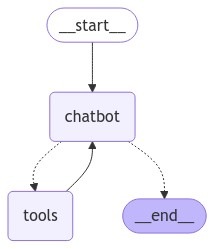

In [7]:
# check graph again
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
# define a function to make graph chat based
def chat_with_agent(prompt: str, session_id: str):
    response = graph.invoke(
        {"messages": ("user", prompt)},
        {"configurable": {"thread_id": session_id}}
    )
    return response


## Simulate users

In [9]:
user_id = "user_1"
prompt = "Tell me about Langchain"
response = chat_with_agent(prompt, user_id)
display(Markdown(response["messages"][-1].content))

LangChain is an open-source framework designed to facilitate the development of applications powered by large language models (LLMs). It provides a structured approach to building applications that can leverage the capabilities of LLMs for various tasks, such as natural language processing, document analysis, and conversational agents.

### Key Features of LangChain:

1. **Modular Components**: LangChain consists of various building blocks, including chains, agents, and retrieval strategies, which help developers construct the cognitive architecture of their applications.

2. **LangServe**: Introduced in October 2023, LangServe is a deployment tool that facilitates the transition from prototype applications to production-ready solutions.

3. **Integrations**: The framework supports integrations with major cloud services (like Amazon, Google, and Microsoft Azure), various APIs (for news, weather, etc.), and databases (SQL, NoSQL, Redis). It also includes tools for web scraping and document summarization.

4. **User Interaction**: LangChain allows users to interact with applications by asking questions. The framework processes these queries through similarity searches in vector databases to retrieve relevant information, which is then used to generate responses from the LLM.

5. **Community and Development**: Launched in October 2022 by Harrison Chase, LangChain has quickly gained popularity, attracting contributions from a large community of developers. It has received significant funding, indicating strong interest in its potential.

### Use Cases:

LangChain can be applied in various domains, including:

- **Chatbots and Conversational Agents**: Building intelligent systems that can engage in natural conversations with users.
- **Document Analysis and Summarization**: Extracting key information from documents and summarizing content for easier understanding.
- **Code Analysis and Generation**: Assisting developers by analyzing code, generating snippets, and debugging.
- **Information Retrieval**: Performing similarity searches to retrieve relevant data based on user queries.
- **Task Automation**: Streamlining workflows by automating repetitive tasks through integrations with various tools and services.

Overall, LangChain serves as a powerful framework for developers looking to harness the capabilities of LLMs, enabling the creation of sophisticated applications across different industries.

In [10]:
# continue conversation following subject
prompt = "What is it used for?"
response = chat_with_agent(prompt, user_id)
display(Markdown(response["messages"][-1].content))

LangChain is used for a variety of applications that leverage the capabilities of large language models (LLMs). Here are some common use cases:

1. **Chatbots and Conversational Agents**: LangChain can be used to build intelligent chatbots that can understand and respond to user queries in a conversational manner.

2. **Document Analysis and Summarization**: It allows for the extraction of key information from documents, summarizing content, and providing insights based on the text.

3. **Code Analysis and Generation**: Developers can use LangChain to analyze code, generate code snippets, and assist in debugging processes.

4. **Information Retrieval**: LangChain can perform similarity searches in vector databases to retrieve relevant information based on user queries, making it useful for knowledge management systems.

5. **Data Integration**: It integrates with various APIs and data sources, enabling applications to pull in data from different platforms for analysis or reporting.

6. **Task Automation**: LangChain can automate repetitive tasks by integrating with tools and services, streamlining workflows.

7. **Multi-Actor Applications**: It supports the development of stateful applications where multiple actors can interact, making it suitable for complex applications that require collaboration.

8. **Learning and Education**: LangChain can be used to create educational tools that provide explanations, answer questions, and assist with learning new concepts.

Overall, LangChain serves as a powerful framework for developers looking to harness the potential of LLMs in various domains, enhancing the capabilities of applications across industries.

In [ ]:
# TODO - test this cell
# try it with another user
user_id = "user_2"
prompt = "What's the weather in Bogotá?"
response = chat_with_agent(prompt, user_id)
display(Markdown(response["messages"][-1].content))